<a href="https://colab.research.google.com/github/Argentan/DMA_LAB2/blob/master/tutoriales/05_valicacion_sklearn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a Validación de Modelos

Los algoritmos de aprendizaje automático se entrenan mediante la optimizaicón de una función sobre los datos de entrenamiento. Por ende, mal se puede validar la hipótesis aprendida sobre los mismo datos que su usaron para formularla. Si lo hiciéramos, lejos de obtener una métrica adecuada de lo bien que generalizará nuestro modelo, sólo tendríamos una evaluación de qué tan bien se ajusta a los datos de entrenamiento. Cuando ese ajuste es muy fuerte y la generalización es muy mala, se dice que incurrimos en un ajuste exesivo (overfitting).

Exísten una serie de métodos que nos permiten estimar qué tan bien generalizará un determinado modelo. En primer término, la simple división entre entrenamiento y validación puede dar la primera aproximación. Generalizando esta idea, se llega a la técnica de validación cruzada (cross-validation) que es la división en k subconjuntos disyuntos de entrenamiento y validación. Llevado al extremo, tenemos los métodos de dejar-p-afuera (leave p out), que cuando p=1, implica el entrenamiento de n modelos para precedir en cada uno de los casos, habiendo entrenado en todos los demás. 


## Separación simple en entrenamiento y validación

En el tutorial anterior, vimos un ejemplo de tomar un p% de casos al azar para validación, entrenando con el restante (1-p)%. Ese fue un caso de simple separación aleatoria entre entrenamiento y validación. 

Scikit Learn es una librería que no sólo tiene una amplia variedad de algoritmos de aprendizaje automático, sino que provee una gran cantidad de funciones auxiliares para simplificar el tratamiento de los datos, entre ellas, las de validación. 


In [54]:
import numpy as np
import pandas as pd
import seaborn.apionly as sns
import matplotlib.pyplot as plt

from sklearn import model_selection
sns.set()

In [55]:
#setup para el notebook
%matplotlib inline
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

In [58]:
try:
    data = pd.read_csv("../data/titanic_proc.csv", index_col="PassengerId")
except:
    data = pd.read_csv("https://raw.githubusercontent.com/UCEMA-QUANt/Data-Science-for-Finance/master/data/titanic_proc.csv", index_col="PassengerId")
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,NumFam,C,Q,S,Age_nul
PassengerId,,,,,,,,,,,,,,
1,0,3,0,22.00,1,0,0,7.25,0,1,0,0,1,0
2,1,1,1,38.00,1,0,1,71.28,1,1,1,0,0,0
3,1,3,1,26.00,0,0,2,7.92,0,0,0,0,1,0
4,1,1,1,35.00,1,0,3,53.10,2,1,0,0,1,0
5,0,3,0,35.00,0,0,4,8.05,0,0,0,0,1,0


Repasamos como se componen los argumentos de las funciones

In [ ]:
def test(*args, **dict_args):
    print("args", type(args), args)
    print("dict_args", type(dict_args), dict_args)

test(1, 2, 3, 4, test_size=0.1, random_state=0)

args <class 'tuple'> (1, 2, 3, 4)
dict_args <class 'dict'> {'test_size': 0.1, 'random_state': 0}


Vemos la ayuda de la función `train_test_split`

In [ ]:
model_selection.train_test_split?

In [59]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(data.drop("Survived", axis=1), 
                                                                    data.Survived, test_size=0.1, random_state=0)
print(f"X_train: {X_train.shape}")
print(f"X_valid: {X_valid.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_valid: {y_valid.shape}")

X_train: (801, 13)
X_valid: (90, 13)
y_train: (801,)
y_valid: (90,)


In [61]:
print(X_train.head())
y_train.head()

             Pclass  Sex   Age  SibSp  Parch  ...  NumFam  C  Q  S  Age_nul
PassengerId                                   ...                          
816               1    0 29.70      0      0  ...       0  0  0  1        1
878               3    0 19.00      0      0  ...       0  0  0  1        0
194               2    0  3.00      1      1  ...       2  0  0  1        0
524               1    1 44.00      0      1  ...       1  1  0  0        0
635               3    1  9.00      3      2  ...       5  0  0  1        0

[5 rows x 13 columns]


PassengerId
816    0
878    0
194    1
524    1
635    0
Name: Survived, dtype: int64

## Ajuste de Hiperparámetros

Vamos a comenzar ajustando los valores posibles de un parámetro `max_depth` en un modelo de `RandomForestClassifier`

In [ ]:
depths = list(range(2, 40, 2)) + [None]
depths

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, None]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, roc_auc_score

Armamos un DF para guardar los resultados

In [65]:
res = pd.DataFrame([], index=[str(d) for d in depths], columns=["train", "valid"])
res

,train,valid
2,NaN,NaN
4,NaN,NaN
6,NaN,NaN
8,NaN,NaN
10,NaN,NaN
...,...,...
30,NaN,NaN
32,NaN,NaN
34,NaN,NaN
36,NaN,NaN


Luego entrenamos el modelo con los distintos valores del parámetro y vemos como mejora la Entropía cruzada (log loss)

In [66]:
for depth in depths:
    learner = RandomForestClassifier(n_estimators=100, max_depth=depth)
    learner.fit(X_train, y_train)
    res.loc[str(depth), "train"] = log_loss(y_train, learner.predict_proba(X_train))
    res.loc[str(depth), "valid"] = log_loss(y_valid, learner.predict_proba(X_valid))

In [67]:
res

,train,valid
2,0.51,0.48
4,0.42,0.40
6,0.34,0.37
8,0.27,0.38
10,0.20,0.39
...,...,...
30,0.11,0.43
32,0.11,0.43
34,0.11,0.39
36,0.11,0.41


Graficamos el resultado

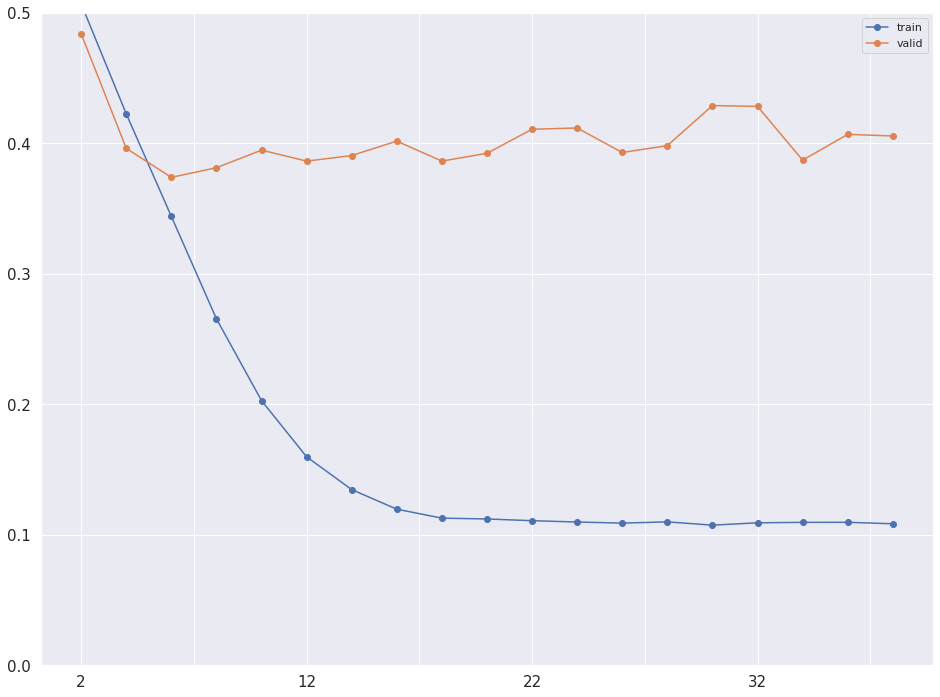

In [68]:
ax = res.plot.line(grid=True, fontsize=15, ylim=(0, 0.5), linestyle='-', style='o')

Ahora, calculamos el área bajo la ROC Curve sobre los mismos modelos


In [69]:
res = pd.DataFrame([], index=[str(d) for d in depths], columns=["train", "valid"])
for depth in depths:
    learner = RandomForestClassifier(n_estimators=100, max_depth=depth)
    learner.fit(X_train, y_train)
    res.loc[str(depth), "train"] = roc_auc_score(y_train, learner.predict_proba(X_train)[:, -1])
    res.loc[str(depth), "valid"] = roc_auc_score(y_valid, learner.predict_proba(X_valid)[:, -1])

In [70]:
res

,train,valid
2,0.85,0.92
4,0.89,0.93
6,0.93,0.93
8,0.97,0.92
10,0.99,0.91
...,...,...
30,1.00,0.89
32,1.00,0.89
34,1.00,0.90
36,1.00,0.90


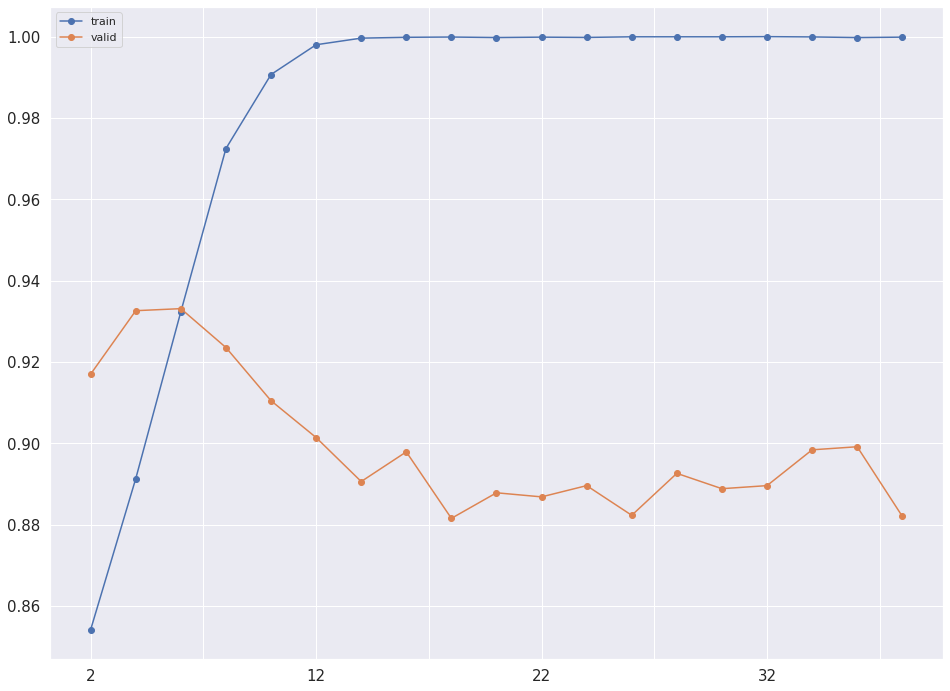

In [71]:
ax = res.plot.line(grid=True, fontsize=15, linestyle='-', style='o')

Veamos como es la supervivencia por deciles

In [72]:
# En Train
pd.crosstab(pd.cut(learner.predict_proba(X_train)[:, -1], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]), y_train)

Survived,0,1
row_0,,
"(0.1, 0.2]",99,0
"(0.2, 0.3]",30,0
"(0.3, 0.4]",9,0
"(0.5, 0.6]",0,3
"(0.6, 0.7]",1,39
"(0.7, 0.8]",0,43


In [ ]:
# En Test
pd.crosstab(pd.cut(learner.predict_proba(X_valid)[:, -1], [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]), y_valid)

Survived,0,1
row_0,,
"(0.1, 0.2]",7,3
"(0.2, 0.3]",9,4
"(0.3, 0.4]",4,3
"(0.4, 0.5]",5,1
"(0.5, 0.6]",0,2
"(0.6, 0.7]",1,4
"(0.7, 0.8]",1,2


In [ ]:
#nota: observar que quitamos el "casting" a str
trees = list(range(1, 100, 10))
trees = trees + list(range(100, 1000, 100))
res = pd.DataFrame([], index=[d for d in trees], columns=["train", "valid"])
for tree in trees:
    learner = RandomForestClassifier(n_estimators=tree, max_depth=6)
    learner.fit(X_train, y_train)
    res.loc[tree, "train"] = roc_auc_score(y_train, learner.predict_proba(X_train)[:, -1])
    res.loc[tree, "valid"] = roc_auc_score(y_valid, learner.predict_proba(X_valid)[:, -1])

In [ ]:
res

,train,valid
1,0.84,0.84
11,0.92,0.93
21,0.93,0.93
31,0.93,0.94
41,0.93,0.94
...,...,...
500,0.93,0.94
600,0.93,0.94
700,0.93,0.94
800,0.94,0.94


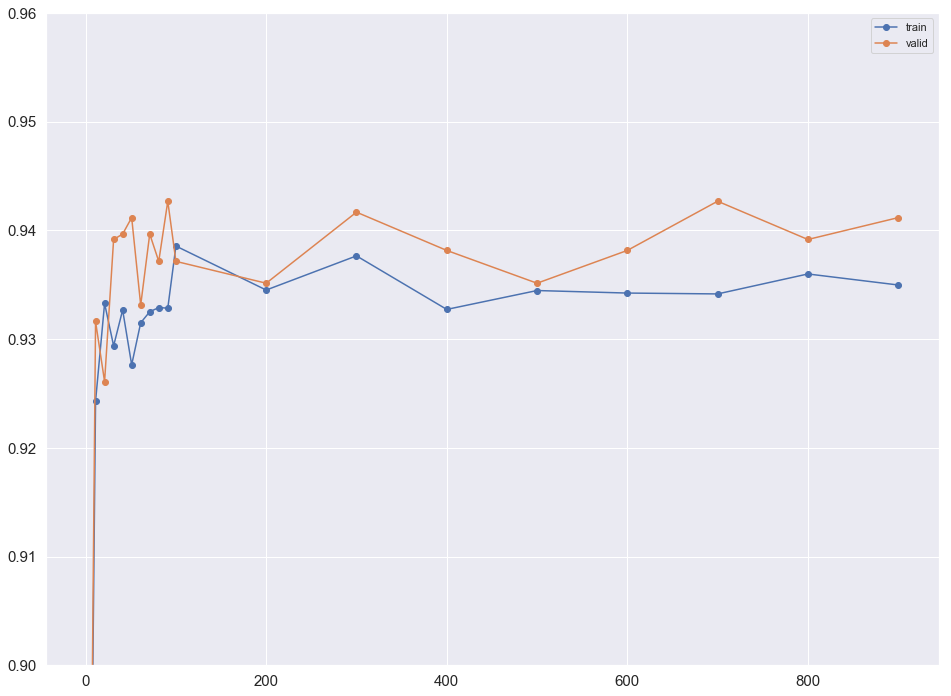

In [ ]:
ax = res.plot.line(grid=True, fontsize=15, ylim=(0.9, 0.96), linestyle='-', style='o')

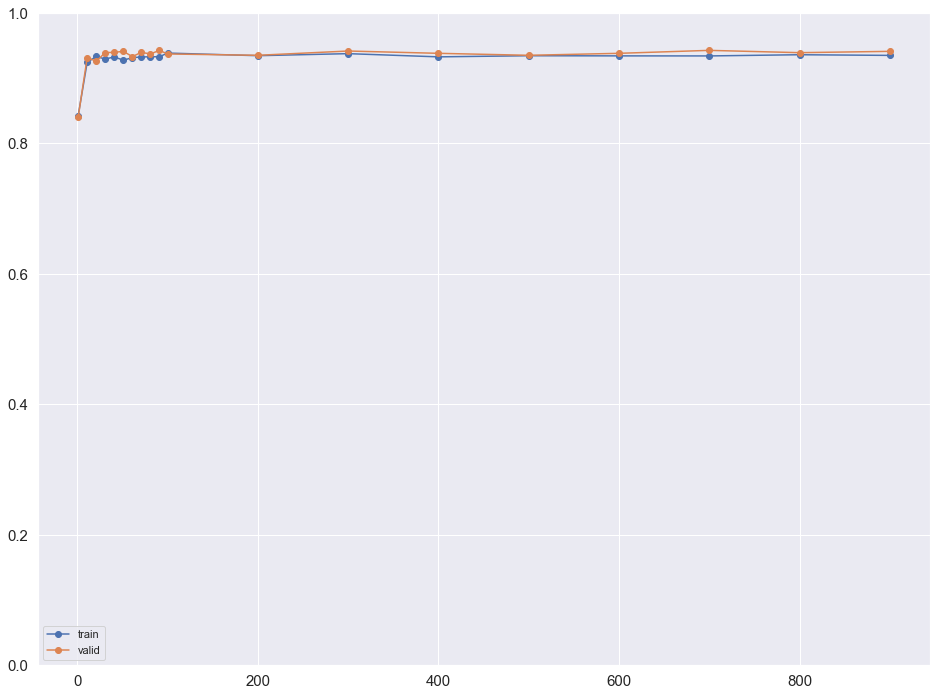

In [ ]:
ax = res.plot.line(grid=True, fontsize=15, ylim=(0, 1), linestyle='-', style='o')

## Validación Cruzada en K conjuntos (K-fold cross validation)

Este método consiste en dividir el set de entrenamiento en K subconjuntos disyuntos, para luego iterativamente entrenar el algoritmo en k-1 partes y evaluar en la restante. 

Scikit Learn también tiene funciones para hacer estas divisiones


In [ ]:
kf = model_selection.KFold(n_splits=5)
folds = [(data.iloc[train_idx].index, data.iloc[valid_idx].index) for train_idx, valid_idx in kf.split(data)]
folds[0]

(Int64Index([180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
             ...
             882, 883, 884, 885, 886, 887, 888, 889, 890, 891],
            dtype='int64', name='PassengerId', length=712),
 Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
             ...
             170, 171, 172, 173, 174, 175, 176, 177, 178, 179],
            dtype='int64', name='PassengerId', length=179))

In [ ]:
folds[0][0].shape, folds[0][1].shape

((712,), (179,))

In [ ]:
res = pd.DataFrame([], index=[str(d) for d in depths], columns=["fold_" + str(i) for i in range(len(folds))] + ["valid"])

for depth in depths:
    valid_probs = []
    for i, (train_idx, valid_idx) in enumerate(folds):
        X_train = data.loc[train_idx]
        y_train = X_train.Survived
        X_train = X_train.drop("Survived", axis=1)
        
        X_valid = data.loc[valid_idx]
        y_valid = X_valid.Survived
        X_valid = X_valid.drop("Survived", axis=1)
        
        learner = RandomForestClassifier(n_estimators=100, max_depth=depth)
        learner.fit(X_train, y_train)
        probs = pd.Series(learner.predict_proba(X_valid)[:, -1], index=X_valid.index)
        valid_probs.append(probs)
        res.loc[str(depth), "fold_" + str(i)] = roc_auc_score(y_valid.loc[probs.index], probs)
    valid_probs = pd.concat(valid_probs)
    res.loc[str(depth), "valid"] = roc_auc_score(data.loc[valid_probs.index, "Survived"], valid_probs)

In [ ]:
res

,fold_0,fold_1,fold_2,fold_3,fold_4,valid
2,0.77,0.85,0.86,0.85,0.89,0.84
4,0.83,0.84,0.87,0.88,0.91,0.86
6,0.84,0.83,0.88,0.88,0.93,0.87
8,0.85,0.84,0.88,0.87,0.92,0.87
10,0.84,0.83,0.89,0.88,0.92,0.87
...,...,...,...,...,...,...
32,0.84,0.82,0.89,0.88,0.90,0.86
34,0.84,0.83,0.89,0.88,0.91,0.86
36,0.84,0.84,0.89,0.87,0.91,0.86
38,0.84,0.83,0.89,0.88,0.91,0.86


In [ ]:
res.sort_values("valid", ascending=False)

,fold_0,fold_1,fold_2,fold_3,fold_4,valid
12,0.84,0.84,0.89,0.89,0.92,0.87
6,0.84,0.83,0.88,0.88,0.93,0.87
8,0.85,0.84,0.88,0.87,0.92,0.87
10,0.84,0.83,0.89,0.88,0.92,0.87
14,0.84,0.84,0.88,0.89,0.91,0.87
...,...,...,...,...,...,...
16,0.83,0.82,0.88,0.88,0.91,0.86
30,0.84,0.83,0.88,0.87,0.90,0.86
32,0.84,0.82,0.89,0.88,0.90,0.86
34,0.84,0.83,0.89,0.88,0.91,0.86


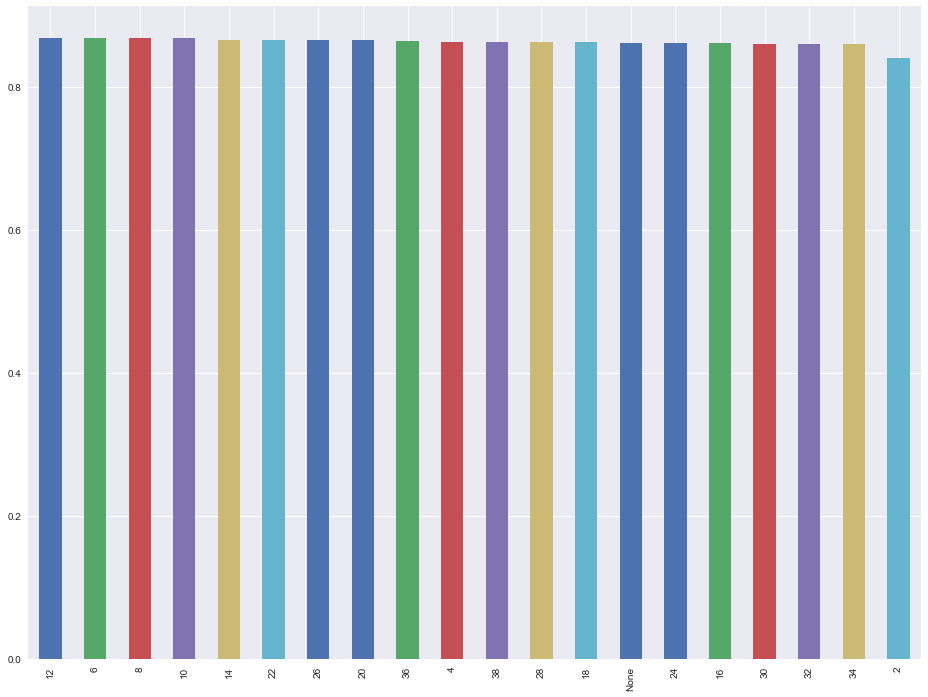

In [ ]:
#diagrama de "pareto"
res.sort_values("valid", ascending=False).valid.plot.bar()

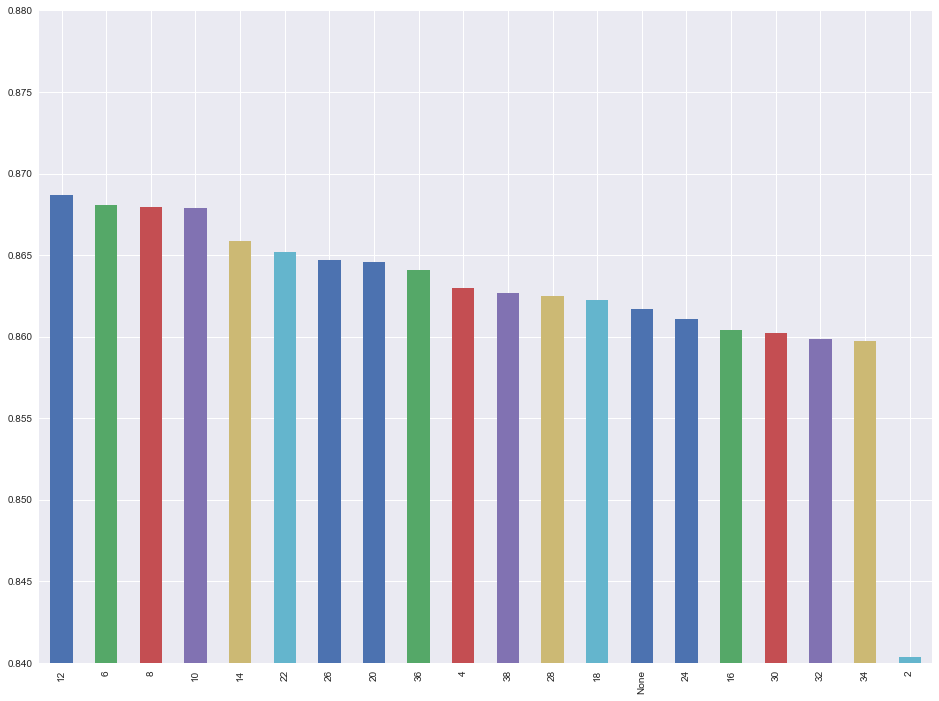

In [ ]:
res.sort_values("valid", ascending=False).valid.plot.bar(ylim=(0.84, 0.88))

## Combinación de métodos  y determinación de cantidad de iteraciones

Ambos métodos se pueden combinar para hacer una estimación mas completa, con el beneficio agregado que, para algunso tipos de algoritmos, se puede facilitar la estimación de la cantidad de iteraciones (ej. boosting o redes neuronales)


In [ ]:
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=0)
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,NumFam,C,Q,S,Age_nul
PassengerId,,,,,,,,,,,,,,
816,0,1,0,29.70,0,0,634,0.00,138,0,0,0,1,1
878,0,3,0,19.00,0,0,671,7.90,0,0,0,0,1,0
194,1,2,0,3.00,1,1,137,26.00,27,2,0,0,1,0
524,1,1,1,44.00,0,1,290,57.98,63,1,1,0,0,0
635,0,3,1,9.00,3,2,62,27.90,0,5,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
836,1,1,1,39.00,1,1,645,83.16,140,2,1,0,0,0
193,1,3,1,19.00,1,0,174,7.85,0,1,0,0,1,0
630,0,3,0,29.70,0,0,512,7.73,0,0,0,1,0,1


In [ ]:
kf = model_selection.KFold(n_splits=5)
folds = [(train.iloc[train_idx].index, train.iloc[valid_idx].index) for train_idx, valid_idx in kf.split(train)]
folds[0]

(Int64Index([334, 699, 482,  72,  50, 574, 339, 262, 117,  77,
             ...
             724,  10, 360, 708, 764, 836, 193, 630, 560, 685],
            dtype='int64', name='PassengerId', length=640),
 Int64Index([816, 878, 194, 524, 635, 532, 248, 267, 695, 682,
             ...
             821, 383,  21, 586,  66, 681, 879, 305, 824, 522],
            dtype='int64', name='PassengerId', length=161))

In [ ]:
from xg import XGBClassifier

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
depths = list(range(2, 40, 2))
res = pd.DataFrame([], index=[str(d) for d in depths], columns=["fold_" + str(i) for i in range(len(folds))] + ["valid", "test"])

for depth in depths:
    valid_probs = []
    test_probs = []
    for i, (train_idx, valid_idx) in enumerate(folds):
        X_train = train.loc[train_idx]
        y_train = X_train.Survived
        X_train = X_train.drop("Survived", axis=1)
        
        X_valid = train.loc[valid_idx]
        y_valid = X_valid.Survived
        X_valid = X_valid.drop("Survived", axis=1)
        
        learner = XGBClassifier(n_estimators=10000, max_depth=depth)
        learner.fit(X_train, y_train,  early_stopping_rounds=10, eval_metric="auc",
                    eval_set=[(X_train, y_train),
                              (test.drop("Survived", axis=1), test.Survived),
                              (X_valid, y_valid)])
        probs = pd.Series(learner.predict_proba(X_valid, ntree_limit=learner.best_ntree_limit)[:, -1], index=X_valid.index)
        valid_probs.append(probs)
        res.loc[str(depth), "fold_" + str(i)] = roc_auc_score(y_valid.loc[probs.index], probs)
        probs = pd.Series(learner.predict_proba(test.drop("Survived", axis=1), ntree_limit=learner.best_ntree_limit)[:, -1], index=test.index, name="fold_" + str(i))
        test_probs.append(probs)
    valid_probs = pd.concat(valid_probs)
    res.loc[str(depth), "valid"] = roc_auc_score(train.loc[valid_probs.index, "Survived"], valid_probs)
    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    res.loc[str(depth), "test"] = roc_auc_score(test.loc[test_probs.index, "Survived"], test_probs)

[0]	validation_0-auc:0.814881	validation_1-auc:0.830317	validation_2-auc:0.831225
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.841376	validation_1-auc:0.917547	validation_2-auc:0.839659
[2]	validation_0-auc:0.844285	validation_1-auc:0.917547	validation_2-auc:0.843033
[3]	validation_0-auc:0.846483	validation_1-auc:0.921066	validation_2-auc:0.84278
[4]	validation_0-auc:0.846483	validation_1-auc:0.921066	validation_2-auc:0.84278
[5]	validation_0-auc:0.847102	validation_1-auc:0.921317	validation_2-auc:0.843792
[6]	validation_0-auc:0.847102	validation_1-auc:0.921317	validation_2-auc:0.843792
[7]	validation_0-auc:0.847102	validation_1-auc:0.921317	validation_2-auc:0.843792
[8]	validation_0-auc:0.84768	validation_1-auc:0.925088	validation_2-auc:0.844045
[9]	validation_0-auc:0.84768	validation_1-auc:0.925088	validation_2-auc:0.844045
[10]	validation_0-auc:0.847

[10]	validation_0-auc:0.850223	validation_1-auc:0.931121	validation_2-auc:0.86942
[11]	validation_0-auc:0.849298	validation_1-auc:0.929613	validation_2-auc:0.86942
[12]	validation_0-auc:0.856059	validation_1-auc:0.933384	validation_2-auc:0.866758
[13]	validation_0-auc:0.855916	validation_1-auc:0.934389	validation_2-auc:0.865556
[14]	validation_0-auc:0.857323	validation_1-auc:0.934892	validation_2-auc:0.866758
[15]	validation_0-auc:0.861649	validation_1-auc:0.935395	validation_2-auc:0.868475
[16]	validation_0-auc:0.861608	validation_1-auc:0.935897	validation_2-auc:0.868475
[17]	validation_0-auc:0.862944	validation_1-auc:0.938663	validation_2-auc:0.869849
[18]	validation_0-auc:0.864424	validation_1-auc:0.937657	validation_2-auc:0.869505
[19]	validation_0-auc:0.867661	validation_1-auc:0.941176	validation_2-auc:0.871223
[20]	validation_0-auc:0.867846	validation_1-auc:0.941176	validation_2-auc:0.871394
[21]	validation_0-auc:0.87023	validation_1-auc:0.944947	validation_2-auc:0.874828
[22]	va

[2]	validation_0-auc:0.835461	validation_1-auc:0.888637	validation_2-auc:0.849511
[3]	validation_0-auc:0.839067	validation_1-auc:0.887381	validation_2-auc:0.84738
[4]	validation_0-auc:0.836638	validation_1-auc:0.887381	validation_2-auc:0.850063
[5]	validation_0-auc:0.83951	validation_1-auc:0.890146	validation_2-auc:0.850616
[6]	validation_0-auc:0.836723	validation_1-auc:0.887632	validation_2-auc:0.850458
[7]	validation_0-auc:0.836723	validation_1-auc:0.887632	validation_2-auc:0.850458
[8]	validation_0-auc:0.838792	validation_1-auc:0.90548	validation_2-auc:0.854482
[9]	validation_0-auc:0.838792	validation_1-auc:0.90548	validation_2-auc:0.854482
[10]	validation_0-auc:0.838792	validation_1-auc:0.90548	validation_2-auc:0.85464
[11]	validation_0-auc:0.844293	validation_1-auc:0.912016	validation_2-auc:0.855035
[12]	validation_0-auc:0.847904	validation_1-auc:0.915535	validation_2-auc:0.861427
[13]	validation_0-auc:0.847397	validation_1-auc:0.916541	validation_2-auc:0.861742
[14]	validation_0-

[20]	validation_0-auc:0.929212	validation_1-auc:0.922826	validation_2-auc:0.841594
[21]	validation_0-auc:0.929387	validation_1-auc:0.921317	validation_2-auc:0.841424
[22]	validation_0-auc:0.93214	validation_1-auc:0.920312	validation_2-auc:0.841594
[23]	validation_0-auc:0.934434	validation_1-auc:0.919558	validation_2-auc:0.837762
[24]	validation_0-auc:0.935309	validation_1-auc:0.917547	validation_2-auc:0.839465
Stopping. Best iteration:
[14]	validation_0-auc:0.912936	validation_1-auc:0.926596	validation_2-auc:0.84449

[0]	validation_0-auc:0.864126	validation_1-auc:0.943942	validation_2-auc:0.871051
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.870024	validation_1-auc:0.948215	validation_2-auc:0.879378
[2]	validation_0-auc:0.872336	validation_1-auc:0.949723	validation_2-auc:0.878177
[3]	validation_0-auc:0.872876	validation_1-auc:0.947461	validation_2-auc:0

Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.891735	validation_1-auc:0.935646	validation_2-auc:0.870698
[2]	validation_0-auc:0.895841	validation_1-auc:0.934389	validation_2-auc:0.869096
[3]	validation_0-auc:0.896563	validation_1-auc:0.932881	validation_2-auc:0.874494
[4]	validation_0-auc:0.901211	validation_1-auc:0.932881	validation_2-auc:0.877024
[5]	validation_0-auc:0.902501	validation_1-auc:0.931373	validation_2-auc:0.878627
[6]	validation_0-auc:0.909501	validation_1-auc:0.934138	validation_2-auc:0.879302
[7]	validation_0-auc:0.912029	validation_1-auc:0.938663	validation_2-auc:0.88276
[8]	validation_0-auc:0.913179	validation_1-auc:0.937406	validation_2-auc:0.885037
[9]	validation_0-auc:0.916017	validation_1-auc:0.935395	validation_2-auc:0.894906
[10]	validation_0-auc:0.923652	validation_1-auc:0.932378	validation_2-auc:0.88664
[11]	validation_0-auc:0.

[17]	validation_0-auc:0.948285	validation_1-auc:0.922574	validation_2-auc:0.814539
[18]	validation_0-auc:0.950729	validation_1-auc:0.918049	validation_2-auc:0.815036
[19]	validation_0-auc:0.954012	validation_1-auc:0.921317	validation_2-auc:0.8205
[20]	validation_0-auc:0.955001	validation_1-auc:0.916792	validation_2-auc:0.820334
[21]	validation_0-auc:0.957378	validation_1-auc:0.913273	validation_2-auc:0.819589
[22]	validation_0-auc:0.961262	validation_1-auc:0.918803	validation_2-auc:0.819838
[23]	validation_0-auc:0.962313	validation_1-auc:0.918803	validation_2-auc:0.816609
[24]	validation_0-auc:0.964524	validation_1-auc:0.915033	validation_2-auc:0.820086
[25]	validation_0-auc:0.966813	validation_1-auc:0.910005	validation_2-auc:0.820914
[26]	validation_0-auc:0.967103	validation_1-auc:0.911513	validation_2-auc:0.818265
[27]	validation_0-auc:0.967413	validation_1-auc:0.910005	validation_2-auc:0.821411
[28]	validation_0-auc:0.968496	validation_1-auc:0.910005	validation_2-auc:0.822984
[29]	v

[25]	validation_0-auc:0.979061	validation_1-auc:0.919558	validation_2-auc:0.900135
[26]	validation_0-auc:0.979989	validation_1-auc:0.916541	validation_2-auc:0.899292
[27]	validation_0-auc:0.981093	validation_1-auc:0.910508	validation_2-auc:0.902834
[28]	validation_0-auc:0.982161	validation_1-auc:0.908497	validation_2-auc:0.902834
[29]	validation_0-auc:0.98278	validation_1-auc:0.913022	validation_2-auc:0.90081
[30]	validation_0-auc:0.983276	validation_1-auc:0.912519	validation_2-auc:0.901316
[31]	validation_0-auc:0.983843	validation_1-auc:0.913524	validation_2-auc:0.900472
[32]	validation_0-auc:0.984328	validation_1-auc:0.912519	validation_2-auc:0.901147
[33]	validation_0-auc:0.984782	validation_1-auc:0.913524	validation_2-auc:0.901484
[34]	validation_0-auc:0.985659	validation_1-auc:0.913022	validation_2-auc:0.900472
[35]	validation_0-auc:0.986144	validation_1-auc:0.915033	validation_2-auc:0.900135
[36]	validation_0-auc:0.986923	validation_1-auc:0.913524	validation_2-auc:0.90081
[37]	va

[3]	validation_0-auc:0.911324	validation_1-auc:0.916541	validation_2-auc:0.861111
[4]	validation_0-auc:0.911277	validation_1-auc:0.913524	validation_2-auc:0.860243
[5]	validation_0-auc:0.9121	validation_1-auc:0.907994	validation_2-auc:0.859927
[6]	validation_0-auc:0.913251	validation_1-auc:0.912519	validation_2-auc:0.859533
[7]	validation_0-auc:0.922453	validation_1-auc:0.907743	validation_2-auc:0.857481
[8]	validation_0-auc:0.935329	validation_1-auc:0.906234	validation_2-auc:0.858191
[9]	validation_0-auc:0.939795	validation_1-auc:0.902715	validation_2-auc:0.853693
[10]	validation_0-auc:0.945634	validation_1-auc:0.899698	validation_2-auc:0.855508
[11]	validation_0-auc:0.948342	validation_1-auc:0.900955	validation_2-auc:0.856929
[12]	validation_0-auc:0.951114	validation_1-auc:0.901458	validation_2-auc:0.856613
Stopping. Best iteration:
[2]	validation_0-auc:0.911134	validation_1-auc:0.918552	validation_2-auc:0.863479

[0]	validation_0-auc:0.892472	validation_1-auc:0.918049	validation_2-a

[8]	validation_0-auc:0.951268	validation_1-auc:0.896933	validation_2-auc:0.819341
[9]	validation_0-auc:0.953691	validation_1-auc:0.883107	validation_2-auc:0.816112
[10]	validation_0-auc:0.961961	validation_1-auc:0.875063	validation_2-auc:0.820583
[11]	validation_0-auc:0.966735	validation_1-auc:0.88009	validation_2-auc:0.820997
[12]	validation_0-auc:0.970505	validation_1-auc:0.882102	validation_2-auc:0.816443
[13]	validation_0-auc:0.972747	validation_1-auc:0.877577	validation_2-auc:0.815946
[14]	validation_0-auc:0.973876	validation_1-auc:0.877074	validation_2-auc:0.813462
[15]	validation_0-auc:0.976403	validation_1-auc:0.878582	validation_2-auc:0.811972
[16]	validation_0-auc:0.978422	validation_1-auc:0.882856	validation_2-auc:0.811061
[17]	validation_0-auc:0.97951	validation_1-auc:0.880342	validation_2-auc:0.808909
[18]	validation_0-auc:0.980732	validation_1-auc:0.88185	validation_2-auc:0.808081
[19]	validation_0-auc:0.981923	validation_1-auc:0.879839	validation_2-auc:0.807336
[20]	vali

[11]	validation_0-auc:0.968529	validation_1-auc:0.88537	validation_2-auc:0.829416
[12]	validation_0-auc:0.971642	validation_1-auc:0.89266	validation_2-auc:0.828905
[13]	validation_0-auc:0.973449	validation_1-auc:0.89266	validation_2-auc:0.831119
[14]	validation_0-auc:0.977879	validation_1-auc:0.892157	validation_2-auc:0.8318
[15]	validation_0-auc:0.979412	validation_1-auc:0.897184	validation_2-auc:0.830778
[16]	validation_0-auc:0.981296	validation_1-auc:0.893162	validation_2-auc:0.829586
[17]	validation_0-auc:0.98339	validation_1-auc:0.889643	validation_2-auc:0.822177
[18]	validation_0-auc:0.9848	validation_1-auc:0.895676	validation_2-auc:0.824647
[19]	validation_0-auc:0.986462	validation_1-auc:0.899698	validation_2-auc:0.822092
[20]	validation_0-auc:0.987542	validation_1-auc:0.896682	validation_2-auc:0.822943
[21]	validation_0-auc:0.988222	validation_1-auc:0.894168	validation_2-auc:0.819877
[22]	validation_0-auc:0.988994	validation_1-auc:0.895425	validation_2-auc:0.817322
[23]	validat

[18]	validation_0-auc:0.981387	validation_1-auc:0.908497	validation_2-auc:0.903424
[19]	validation_0-auc:0.982822	validation_1-auc:0.911513	validation_2-auc:0.903509
[20]	validation_0-auc:0.983951	validation_1-auc:0.912016	validation_2-auc:0.901991
[21]	validation_0-auc:0.984983	validation_1-auc:0.912519	validation_2-auc:0.903171
[22]	validation_0-auc:0.986283	validation_1-auc:0.911011	validation_2-auc:0.906208
[23]	validation_0-auc:0.986985	validation_1-auc:0.912016	validation_2-auc:0.905196
[24]	validation_0-auc:0.98749	validation_1-auc:0.911011	validation_2-auc:0.906714
[25]	validation_0-auc:0.988212	validation_1-auc:0.911011	validation_2-auc:0.906883
[26]	validation_0-auc:0.989017	validation_1-auc:0.910508	validation_2-auc:0.90469
[27]	validation_0-auc:0.989296	validation_1-auc:0.910005	validation_2-auc:0.904521
[28]	validation_0-auc:0.98976	validation_1-auc:0.908497	validation_2-auc:0.905533
[29]	validation_0-auc:0.9904	validation_1-auc:0.906988	validation_2-auc:0.906883
[30]	vali

[5]	validation_0-auc:0.940973	validation_1-auc:0.895173	validation_2-auc:0.805845
[6]	validation_0-auc:0.945038	validation_1-auc:0.895173	validation_2-auc:0.817768
[7]	validation_0-auc:0.958036	validation_1-auc:0.896179	validation_2-auc:0.819921
[8]	validation_0-auc:0.961883	validation_1-auc:0.875314	validation_2-auc:0.817437
[9]	validation_0-auc:0.966844	validation_1-auc:0.885118	validation_2-auc:0.818679
[10]	validation_0-auc:0.969153	validation_1-auc:0.875566	validation_2-auc:0.816692
[11]	validation_0-auc:0.973342	validation_1-auc:0.878079	validation_2-auc:0.811475
[12]	validation_0-auc:0.976268	validation_1-auc:0.882102	validation_2-auc:0.807998
[13]	validation_0-auc:0.978065	validation_1-auc:0.88009	validation_2-auc:0.803196
[14]	validation_0-auc:0.979908	validation_1-auc:0.885118	validation_2-auc:0.799884
[15]	validation_0-auc:0.982316	validation_1-auc:0.883107	validation_2-auc:0.805183
[16]	validation_0-auc:0.983859	validation_1-auc:0.889392	validation_2-auc:0.803775
[17]	valid

[22]	validation_0-auc:0.989848	validation_1-auc:0.890397	validation_2-auc:0.822177
[23]	validation_0-auc:0.990517	validation_1-auc:0.891403	validation_2-auc:0.821836
[24]	validation_0-auc:0.991	validation_1-auc:0.891905	validation_2-auc:0.821836
[25]	validation_0-auc:0.991309	validation_1-auc:0.8909	validation_2-auc:0.821325
[26]	validation_0-auc:0.991752	validation_1-auc:0.889392	validation_2-auc:0.823199
[27]	validation_0-auc:0.99242	validation_1-auc:0.888386	validation_2-auc:0.823369
Stopping. Best iteration:
[17]	validation_0-auc:0.984213	validation_1-auc:0.902212	validation_2-auc:0.82618

[0]	validation_0-auc:0.89335	validation_1-auc:0.930116	validation_2-auc:0.879979
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.901282	validation_1-auc:0.928859	validation_2-auc:0.891484
[2]	validation_0-auc:0.906646	validation_1-auc:0.925591	validation_2-auc:0.8950

[26]	validation_0-auc:0.988991	validation_1-auc:0.904977	validation_2-auc:0.907726
[27]	validation_0-auc:0.989476	validation_1-auc:0.903972	validation_2-auc:0.909076
[28]	validation_0-auc:0.989961	validation_1-auc:0.90548	validation_2-auc:0.908232
[29]	validation_0-auc:0.990518	validation_1-auc:0.906486	validation_2-auc:0.90975
[30]	validation_0-auc:0.991065	validation_1-auc:0.902966	validation_2-auc:0.911437
[31]	validation_0-auc:0.991808	validation_1-auc:0.902966	validation_2-auc:0.910256
[32]	validation_0-auc:0.992241	validation_1-auc:0.89995	validation_2-auc:0.912618
[33]	validation_0-auc:0.992799	validation_1-auc:0.89995	validation_2-auc:0.910594
[34]	validation_0-auc:0.993438	validation_1-auc:0.902464	validation_2-auc:0.910088
[35]	validation_0-auc:0.993851	validation_1-auc:0.901458	validation_2-auc:0.909244
[36]	validation_0-auc:0.994356	validation_1-auc:0.902966	validation_2-auc:0.90975
[37]	validation_0-auc:0.994738	validation_1-auc:0.900452	validation_2-auc:0.90857
[38]	valid

[1]	validation_0-auc:0.89697	validation_1-auc:0.894419	validation_2-auc:0.851641
[2]	validation_0-auc:0.9105	validation_1-auc:0.922071	validation_2-auc:0.857797
[3]	validation_0-auc:0.912158	validation_1-auc:0.918552	validation_2-auc:0.858665
[4]	validation_0-auc:0.934595	validation_1-auc:0.90372	validation_2-auc:0.849905
[5]	validation_0-auc:0.948923	validation_1-auc:0.901207	validation_2-auc:0.845092
[6]	validation_0-auc:0.954435	validation_1-auc:0.899698	validation_2-auc:0.842645
[7]	validation_0-auc:0.953959	validation_1-auc:0.897687	validation_2-auc:0.846749
[8]	validation_0-auc:0.963716	validation_1-auc:0.889894	validation_2-auc:0.846433
[9]	validation_0-auc:0.968398	validation_1-auc:0.884867	validation_2-auc:0.84596
[10]	validation_0-auc:0.971999	validation_1-auc:0.888637	validation_2-auc:0.850773
[11]	validation_0-auc:0.974052	validation_1-auc:0.88914	validation_2-auc:0.85614
[12]	validation_0-auc:0.9758	validation_1-auc:0.891151	validation_2-auc:0.854009
[13]	validation_0-auc:

[7]	validation_0-auc:0.958908	validation_1-auc:0.922071	validation_2-auc:0.890539
[8]	validation_0-auc:0.964174	validation_1-auc:0.921569	validation_2-auc:0.890024
[9]	validation_0-auc:0.967134	validation_1-auc:0.923077	validation_2-auc:0.889852
[10]	validation_0-auc:0.970787	validation_1-auc:0.919055	validation_2-auc:0.890883
[11]	validation_0-auc:0.973669	validation_1-auc:0.91629	validation_2-auc:0.895347
[12]	validation_0-auc:0.975097	validation_1-auc:0.913273	validation_2-auc:0.896892
[13]	validation_0-auc:0.976772	validation_1-auc:0.915033	validation_2-auc:0.896892
[14]	validation_0-auc:0.978586	validation_1-auc:0.915535	validation_2-auc:0.896034
[15]	validation_0-auc:0.979993	validation_1-auc:0.918049	validation_2-auc:0.89672
[16]	validation_0-auc:0.981257	validation_1-auc:0.917044	validation_2-auc:0.894231
[17]	validation_0-auc:0.982326	validation_1-auc:0.916541	validation_2-auc:0.893973
[18]	validation_0-auc:0.983451	validation_1-auc:0.916541	validation_2-auc:0.893544
[19]	vali

[42]	validation_0-auc:0.996698	validation_1-auc:0.898441	validation_2-auc:0.907895
Stopping. Best iteration:
[32]	validation_0-auc:0.992241	validation_1-auc:0.89995	validation_2-auc:0.912618

[0]	validation_0-auc:0.911485	validation_1-auc:0.904223	validation_2-auc:0.798416
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.913903	validation_1-auc:0.903218	validation_2-auc:0.800545
[2]	validation_0-auc:0.920495	validation_1-auc:0.901458	validation_2-auc:0.802589
[3]	validation_0-auc:0.921637	validation_1-auc:0.898441	validation_2-auc:0.80327
[4]	validation_0-auc:0.92298	validation_1-auc:0.897436	validation_2-auc:0.800375
[5]	validation_0-auc:0.92422	validation_1-auc:0.898693	validation_2-auc:0.79799
[6]	validation_0-auc:0.925538	validation_1-auc:0.900201	validation_2-auc:0.800375
[7]	validation_0-auc:0.927107	validation_1-auc:0.914279	validation_2-auc:0.814682

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.906334	validation_1-auc:0.915033	validation_2-auc:0.884109
[2]	validation_0-auc:0.906256	validation_1-auc:0.91277	validation_2-auc:0.883266
[3]	validation_0-auc:0.9101	validation_1-auc:0.912519	validation_2-auc:0.888327
[4]	validation_0-auc:0.91289	validation_1-auc:0.915787	validation_2-auc:0.884447
[5]	validation_0-auc:0.933618	validation_1-auc:0.915284	validation_2-auc:0.884868
[6]	validation_0-auc:0.942486	validation_1-auc:0.911011	validation_2-auc:0.890604
[7]	validation_0-auc:0.945591	validation_1-auc:0.915535	validation_2-auc:0.890773
[8]	validation_0-auc:0.949641	validation_1-auc:0.917044	validation_2-auc:0.884362
[9]	validation_0-auc:0.955238	validation_1-auc:0.917295	validation_2-auc:0.888158
[10]	validation_0-auc:0.95954	validation_1-auc:0.913776	validation_2-auc:0.886134
[11]	validation_0-auc:0.964735	validation_1-auc:0.911765	validation_2-auc:0.89052
[12]	validation_0-auc:0.967015	validat

Stopping. Best iteration:
[12]	validation_0-auc:0.975097	validation_1-auc:0.913273	validation_2-auc:0.896892

[0]	validation_0-auc:0.898652	validation_1-auc:0.90724	validation_2-auc:0.808992
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.899993	validation_1-auc:0.906988	validation_2-auc:0.814125
[2]	validation_0-auc:0.912229	validation_1-auc:0.909251	validation_2-auc:0.80924
[3]	validation_0-auc:0.910893	validation_1-auc:0.911765	validation_2-auc:0.807087
[4]	validation_0-auc:0.923838	validation_1-auc:0.910005	validation_2-auc:0.805928
[5]	validation_0-auc:0.940973	validation_1-auc:0.895173	validation_2-auc:0.805845
[6]	validation_0-auc:0.945421	validation_1-auc:0.895676	validation_2-auc:0.820748
[7]	validation_0-auc:0.958331	validation_1-auc:0.895173	validation_2-auc:0.821742
[8]	validation_0-auc:0.962137	validation_1-auc:0.875314	validation_2-auc:0.8199

[12]	validation_0-auc:0.973665	validation_1-auc:0.885872	validation_2-auc:0.817578
[13]	validation_0-auc:0.975702	validation_1-auc:0.882353	validation_2-auc:0.821921
[14]	validation_0-auc:0.978604	validation_1-auc:0.882604	validation_2-auc:0.821751
[15]	validation_0-auc:0.980858	validation_1-auc:0.889643	validation_2-auc:0.82141
[16]	validation_0-auc:0.98267	validation_1-auc:0.895676	validation_2-auc:0.825669
[17]	validation_0-auc:0.984213	validation_1-auc:0.902212	validation_2-auc:0.82618
[18]	validation_0-auc:0.985371	validation_1-auc:0.897184	validation_2-auc:0.825072
[19]	validation_0-auc:0.986904	validation_1-auc:0.896179	validation_2-auc:0.820303
[20]	validation_0-auc:0.988222	validation_1-auc:0.894671	validation_2-auc:0.820473
[21]	validation_0-auc:0.989168	validation_1-auc:0.89266	validation_2-auc:0.822006
[22]	validation_0-auc:0.989848	validation_1-auc:0.890397	validation_2-auc:0.822177
[23]	validation_0-auc:0.990517	validation_1-auc:0.891403	validation_2-auc:0.821836
[24]	val

[16]	validation_0-auc:0.97823	validation_1-auc:0.909754	validation_2-auc:0.89887
[17]	validation_0-auc:0.980103	validation_1-auc:0.907994	validation_2-auc:0.897352
[18]	validation_0-auc:0.981341	validation_1-auc:0.906988	validation_2-auc:0.902075
[19]	validation_0-auc:0.982785	validation_1-auc:0.909	validation_2-auc:0.903003
[20]	validation_0-auc:0.984214	validation_1-auc:0.907491	validation_2-auc:0.904858
[21]	validation_0-auc:0.984988	validation_1-auc:0.906988	validation_2-auc:0.905533
[22]	validation_0-auc:0.986154	validation_1-auc:0.906486	validation_2-auc:0.908738
[23]	validation_0-auc:0.986866	validation_1-auc:0.909	validation_2-auc:0.907726
[24]	validation_0-auc:0.987413	validation_1-auc:0.906486	validation_2-auc:0.909919
[25]	validation_0-auc:0.988125	validation_1-auc:0.907491	validation_2-auc:0.909919
[26]	validation_0-auc:0.988991	validation_1-auc:0.904977	validation_2-auc:0.907726
[27]	validation_0-auc:0.989476	validation_1-auc:0.903972	validation_2-auc:0.909076
[28]	validat

[12]	validation_0-auc:0.976367	validation_1-auc:0.876068	validation_2-auc:0.815615
[13]	validation_0-auc:0.978521	validation_1-auc:0.88009	validation_2-auc:0.811475
[14]	validation_0-auc:0.980173	validation_1-auc:0.879085	validation_2-auc:0.80866
[15]	validation_0-auc:0.982244	validation_1-auc:0.879588	validation_2-auc:0.807667
[16]	validation_0-auc:0.983673	validation_1-auc:0.884867	validation_2-auc:0.804603
[17]	validation_0-auc:0.98475	validation_1-auc:0.880342	validation_2-auc:0.805017
Stopping. Best iteration:
[7]	validation_0-auc:0.958331	validation_1-auc:0.895173	validation_2-auc:0.821742

[0]	validation_0-auc:0.895444	validation_1-auc:0.89266	validation_2-auc:0.853693
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.89697	validation_1-auc:0.894419	validation_2-auc:0.851641
[2]	validation_0-auc:0.9105	validation_1-auc:0.922071	validation_2-auc:0.8577

Stopping. Best iteration:
[17]	validation_0-auc:0.984213	validation_1-auc:0.902212	validation_2-auc:0.82618

[0]	validation_0-auc:0.89335	validation_1-auc:0.930116	validation_2-auc:0.879979
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.901282	validation_1-auc:0.928859	validation_2-auc:0.891484
[2]	validation_0-auc:0.906646	validation_1-auc:0.925591	validation_2-auc:0.895089
[3]	validation_0-auc:0.912	validation_1-auc:0.921066	validation_2-auc:0.892857
[4]	validation_0-auc:0.943525	validation_1-auc:0.915787	validation_2-auc:0.887363
[5]	validation_0-auc:0.945637	validation_1-auc:0.909754	validation_2-auc:0.887363
[6]	validation_0-auc:0.954037	validation_1-auc:0.922323	validation_2-auc:0.887448
[7]	validation_0-auc:0.958908	validation_1-auc:0.922071	validation_2-auc:0.890539
[8]	validation_0-auc:0.964174	validation_1-auc:0.921569	validation_2-auc:0.890024


[32]	validation_0-auc:0.992241	validation_1-auc:0.89995	validation_2-auc:0.912618
[33]	validation_0-auc:0.992799	validation_1-auc:0.89995	validation_2-auc:0.910594
[34]	validation_0-auc:0.993438	validation_1-auc:0.902464	validation_2-auc:0.910088
[35]	validation_0-auc:0.993851	validation_1-auc:0.901458	validation_2-auc:0.909244
[36]	validation_0-auc:0.994356	validation_1-auc:0.902966	validation_2-auc:0.90975
[37]	validation_0-auc:0.994738	validation_1-auc:0.900452	validation_2-auc:0.90857
[38]	validation_0-auc:0.995099	validation_1-auc:0.901961	validation_2-auc:0.90857
[39]	validation_0-auc:0.995357	validation_1-auc:0.899447	validation_2-auc:0.907895
[40]	validation_0-auc:0.995935	validation_1-auc:0.898944	validation_2-auc:0.907389
[41]	validation_0-auc:0.996183	validation_1-auc:0.897436	validation_2-auc:0.90857
[42]	validation_0-auc:0.996698	validation_1-auc:0.898441	validation_2-auc:0.907895
Stopping. Best iteration:
[32]	validation_0-auc:0.992241	validation_1-auc:0.89995	validation_

[7]	validation_0-auc:0.953959	validation_1-auc:0.897687	validation_2-auc:0.846749
[8]	validation_0-auc:0.963716	validation_1-auc:0.889894	validation_2-auc:0.846433
[9]	validation_0-auc:0.968398	validation_1-auc:0.884867	validation_2-auc:0.84596
[10]	validation_0-auc:0.971999	validation_1-auc:0.888637	validation_2-auc:0.850773
[11]	validation_0-auc:0.974052	validation_1-auc:0.88914	validation_2-auc:0.85614
[12]	validation_0-auc:0.975842	validation_1-auc:0.891654	validation_2-auc:0.854325
[13]	validation_0-auc:0.978466	validation_1-auc:0.891905	validation_2-auc:0.855193
Stopping. Best iteration:
[3]	validation_0-auc:0.912158	validation_1-auc:0.918552	validation_2-auc:0.858665

[0]	validation_0-auc:0.892472	validation_1-auc:0.918049	validation_2-auc:0.85054
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.906334	validation_1-auc:0.915033	validation_2-auc:0.884

[13]	validation_0-auc:0.976772	validation_1-auc:0.915033	validation_2-auc:0.896892
[14]	validation_0-auc:0.978586	validation_1-auc:0.915535	validation_2-auc:0.896034
[15]	validation_0-auc:0.979993	validation_1-auc:0.918049	validation_2-auc:0.89672
[16]	validation_0-auc:0.981257	validation_1-auc:0.917044	validation_2-auc:0.894231
[17]	validation_0-auc:0.982326	validation_1-auc:0.916541	validation_2-auc:0.893973
[18]	validation_0-auc:0.983451	validation_1-auc:0.916541	validation_2-auc:0.893544
[19]	validation_0-auc:0.984782	validation_1-auc:0.915033	validation_2-auc:0.893544
[20]	validation_0-auc:0.986015	validation_1-auc:0.915033	validation_2-auc:0.89363
[21]	validation_0-auc:0.986863	validation_1-auc:0.917044	validation_2-auc:0.893458
[22]	validation_0-auc:0.987767	validation_1-auc:0.915535	validation_2-auc:0.894145
Stopping. Best iteration:
[12]	validation_0-auc:0.975097	validation_1-auc:0.913273	validation_2-auc:0.896892

[0]	validation_0-auc:0.898652	validation_1-auc:0.90724	validat

[2]	validation_0-auc:0.920495	validation_1-auc:0.901458	validation_2-auc:0.802589
[3]	validation_0-auc:0.921637	validation_1-auc:0.898441	validation_2-auc:0.80327
[4]	validation_0-auc:0.92298	validation_1-auc:0.897436	validation_2-auc:0.800375
[5]	validation_0-auc:0.92422	validation_1-auc:0.898693	validation_2-auc:0.79799
[6]	validation_0-auc:0.925538	validation_1-auc:0.900201	validation_2-auc:0.800375
[7]	validation_0-auc:0.927107	validation_1-auc:0.914279	validation_2-auc:0.814682
[8]	validation_0-auc:0.953005	validation_1-auc:0.902212	validation_2-auc:0.812127
[9]	validation_0-auc:0.96167	validation_1-auc:0.891151	validation_2-auc:0.820473
[10]	validation_0-auc:0.965545	validation_1-auc:0.890649	validation_2-auc:0.824987
[11]	validation_0-auc:0.970778	validation_1-auc:0.881096	validation_2-auc:0.824561
[12]	validation_0-auc:0.973665	validation_1-auc:0.885872	validation_2-auc:0.817578
[13]	validation_0-auc:0.975702	validation_1-auc:0.882353	validation_2-auc:0.821921
[14]	validation_0

[6]	validation_0-auc:0.942486	validation_1-auc:0.911011	validation_2-auc:0.890604
[7]	validation_0-auc:0.945591	validation_1-auc:0.915535	validation_2-auc:0.890773
[8]	validation_0-auc:0.949641	validation_1-auc:0.917044	validation_2-auc:0.884362
[9]	validation_0-auc:0.955238	validation_1-auc:0.917295	validation_2-auc:0.888158
[10]	validation_0-auc:0.95954	validation_1-auc:0.913776	validation_2-auc:0.886134
[11]	validation_0-auc:0.964735	validation_1-auc:0.911765	validation_2-auc:0.89052
[12]	validation_0-auc:0.967015	validation_1-auc:0.911011	validation_2-auc:0.887652
[13]	validation_0-auc:0.970363	validation_1-auc:0.910508	validation_2-auc:0.892206
[14]	validation_0-auc:0.97368	validation_1-auc:0.909251	validation_2-auc:0.894146
[15]	validation_0-auc:0.975873	validation_1-auc:0.909251	validation_2-auc:0.89499
[16]	validation_0-auc:0.97823	validation_1-auc:0.909754	validation_2-auc:0.89887
[17]	validation_0-auc:0.980103	validation_1-auc:0.907994	validation_2-auc:0.897352
[18]	validatio

[2]	validation_0-auc:0.912229	validation_1-auc:0.909251	validation_2-auc:0.80924
[3]	validation_0-auc:0.910893	validation_1-auc:0.911765	validation_2-auc:0.807087
[4]	validation_0-auc:0.923838	validation_1-auc:0.910005	validation_2-auc:0.805928
[5]	validation_0-auc:0.940973	validation_1-auc:0.895173	validation_2-auc:0.805845
[6]	validation_0-auc:0.945421	validation_1-auc:0.895676	validation_2-auc:0.820748
[7]	validation_0-auc:0.958331	validation_1-auc:0.895173	validation_2-auc:0.821742
[8]	validation_0-auc:0.962137	validation_1-auc:0.875314	validation_2-auc:0.819921
[9]	validation_0-auc:0.967413	validation_1-auc:0.884615	validation_2-auc:0.818016
[10]	validation_0-auc:0.97021	validation_1-auc:0.88009	validation_2-auc:0.821659
[11]	validation_0-auc:0.972353	validation_1-auc:0.876068	validation_2-auc:0.820417
[12]	validation_0-auc:0.976367	validation_1-auc:0.876068	validation_2-auc:0.815615
[13]	validation_0-auc:0.978521	validation_1-auc:0.88009	validation_2-auc:0.811475
[14]	validation_

In [ ]:
res

,fold_0,fold_1,fold_2,fold_3,fold_4,valid,test
2,0.87,0.85,0.88,0.85,0.90,0.86,0.96
4,0.89,0.84,0.90,0.82,0.88,0.87,0.94
6,0.91,0.85,0.89,0.84,0.86,0.84,0.93
8,0.90,0.85,0.90,0.81,0.86,0.85,0.92
10,0.90,0.83,0.90,0.82,0.86,0.84,0.92
...,...,...,...,...,...,...,...
30,0.91,0.83,0.90,0.82,0.86,0.85,0.92
32,0.91,0.83,0.90,0.82,0.86,0.85,0.92
34,0.91,0.83,0.90,0.82,0.86,0.85,0.92
36,0.91,0.83,0.90,0.82,0.86,0.85,0.92


In [ ]:
res.sort_values("test", ascending=False)

,fold_0,fold_1,fold_2,fold_3,fold_4,valid,test
2,0.87,0.85,0.88,0.85,0.90,0.86,0.96
4,0.89,0.84,0.90,0.82,0.88,0.87,0.94
6,0.91,0.85,0.89,0.84,0.86,0.84,0.93
14,0.91,0.83,0.90,0.82,0.86,0.86,0.92
10,0.90,0.83,0.90,0.82,0.86,0.84,0.92
...,...,...,...,...,...,...,...
18,0.91,0.83,0.90,0.82,0.86,0.85,0.92
38,0.91,0.83,0.90,0.82,0.86,0.85,0.92
16,0.91,0.83,0.90,0.82,0.86,0.85,0.92
12,0.90,0.83,0.90,0.82,0.86,0.84,0.92


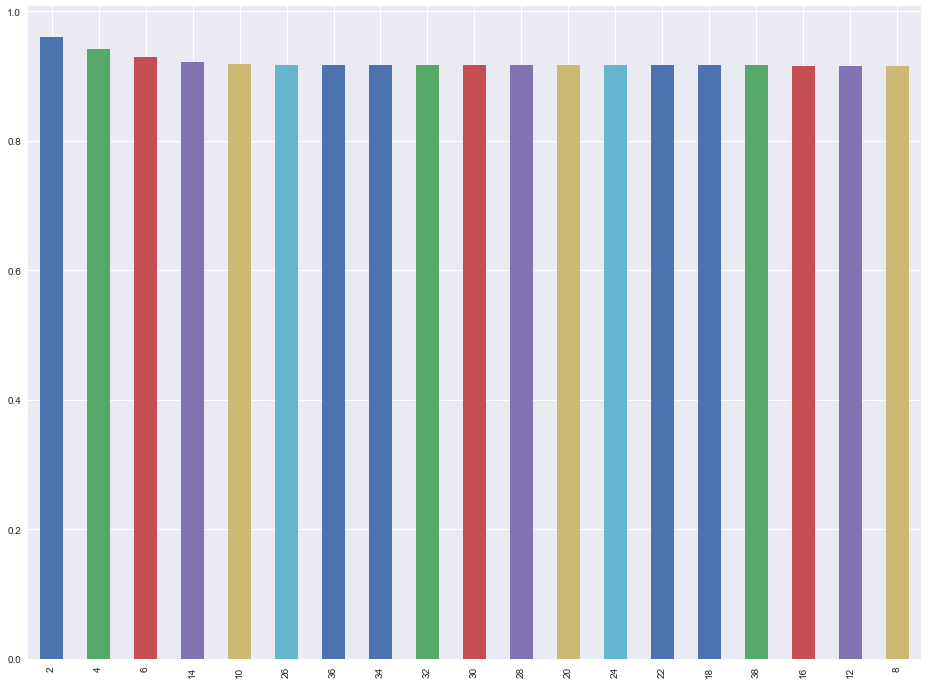

In [ ]:
res.sort_values("test", ascending=False).test.plot.bar()

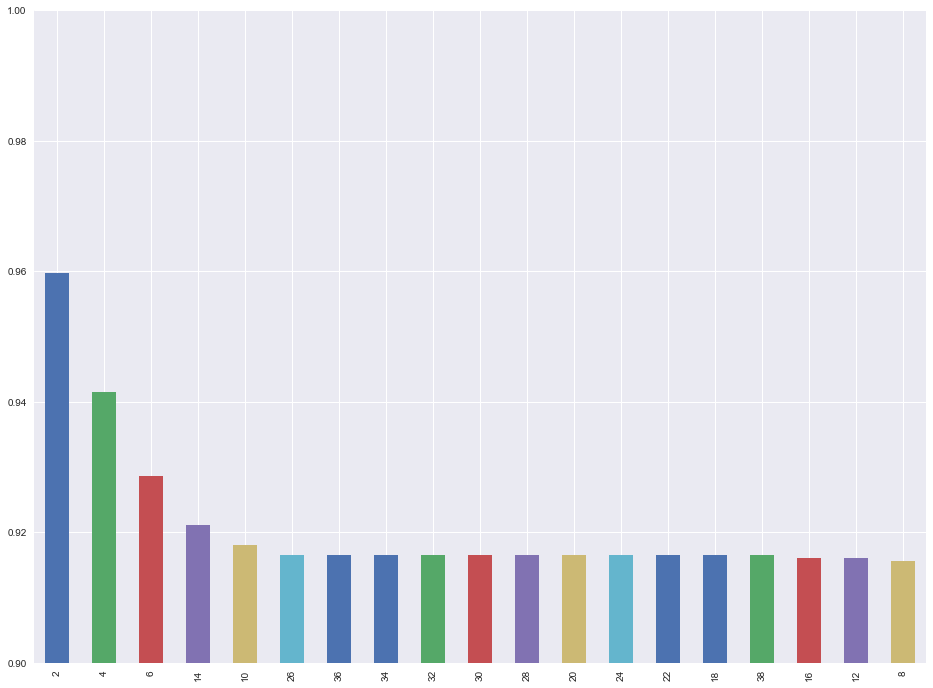

In [ ]:
res.sort_values("test", ascending=False).test.plot.bar(ylim=(0.9, 1))

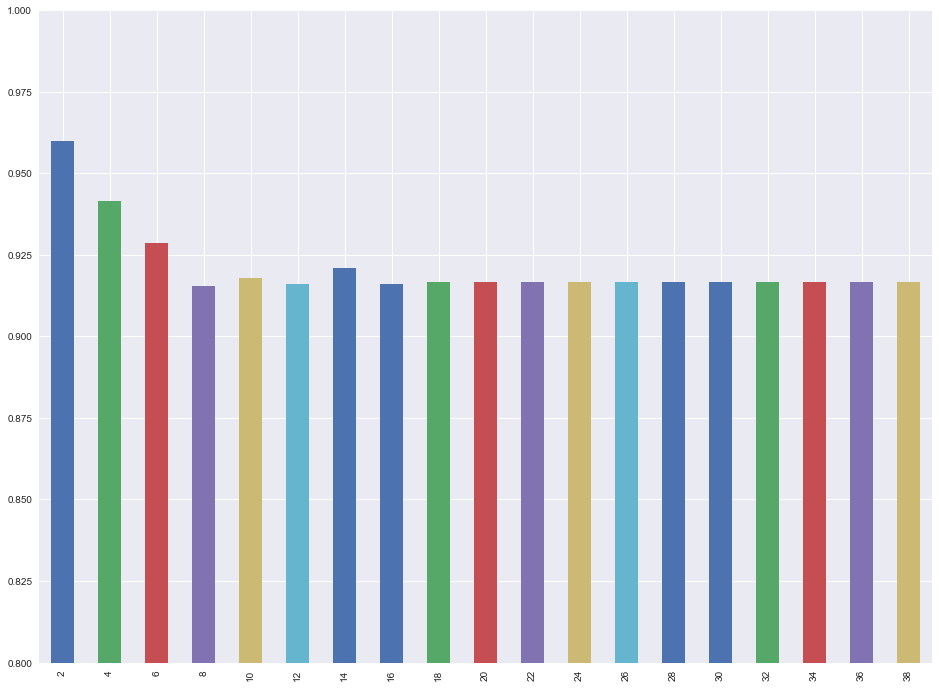

In [ ]:
res.test.plot.bar(ylim=(0.8, 1))

In [ ]:
res = pd.DataFrame([], index=[str(d) for d in depths], columns=["fold_" + str(i) for i in range(len(folds))] + ["valid", "test"])

for depth in depths:
    valid_probs = []
    test_probs = []
    for i, (train_idx, valid_idx) in enumerate(folds):
        print("doing fold {0} of depth {1}".format(i + 1, str(depth)))
        X_train = train.loc[train_idx]
        y_train = X_train.Survived
        X_train = X_train.drop("Survived", axis=1)
        
        X_valid = train.loc[valid_idx]
        y_valid = X_valid.Survived
        X_valid = X_valid.drop("Survived", axis=1)
        
        learner = RandomForestClassifier(n_estimators=100, max_depth=depth, n_jobs=-1)
        learner.fit(X_train, y_train)
        probs = pd.Series(learner.predict_proba(X_valid)[:, -1], index=X_valid.index)
        valid_probs.append(probs)
        res.loc[str(depth), "fold_" + str(i)] = roc_auc_score(y_valid.loc[probs.index], probs)
        probs = pd.Series(learner.predict_proba(test.drop("Survived", axis=1))[:, -1], index=test.index, name="fold_" + str(i))
        test_probs.append(probs)
    valid_probs = pd.concat(valid_probs)
    res.loc[str(depth), "valid"] = roc_auc_score(train.loc[valid_probs.index, "Survived"], valid_probs)
    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    res.loc[str(depth), "test"] = roc_auc_score(test.loc[test_probs.index, "Survived"], test_probs)

doing fold 1 of depth 2
doing fold 2 of depth 2
doing fold 3 of depth 2
doing fold 4 of depth 2
doing fold 5 of depth 2
doing fold 1 of depth 4
doing fold 2 of depth 4
doing fold 3 of depth 4
doing fold 4 of depth 4
doing fold 5 of depth 4
doing fold 1 of depth 6
doing fold 2 of depth 6
doing fold 3 of depth 6
doing fold 4 of depth 6
doing fold 5 of depth 6
doing fold 1 of depth 8
doing fold 2 of depth 8
doing fold 3 of depth 8
doing fold 4 of depth 8
doing fold 5 of depth 8
doing fold 1 of depth 10
doing fold 2 of depth 10
doing fold 3 of depth 10
doing fold 4 of depth 10
doing fold 5 of depth 10
doing fold 1 of depth 12
doing fold 2 of depth 12
doing fold 3 of depth 12
doing fold 4 of depth 12
doing fold 5 of depth 12
doing fold 1 of depth 14
doing fold 2 of depth 14
doing fold 3 of depth 14
doing fold 4 of depth 14
doing fold 5 of depth 14
doing fold 1 of depth 16
doing fold 2 of depth 16
doing fold 3 of depth 16
doing fold 4 of depth 16
doing fold 5 of depth 16
doing fold 1 of dept

In [ ]:
res.sort_values("test", ascending=False)

,fold_0,fold_1,fold_2,fold_3,fold_4,valid,test
6,0.88,0.83,0.88,0.84,0.88,0.86,0.94
4,0.87,0.82,0.88,0.84,0.88,0.86,0.94
8,0.88,0.84,0.88,0.82,0.87,0.86,0.93
2,0.87,0.80,0.86,0.82,0.87,0.84,0.93
12,0.90,0.83,0.89,0.83,0.87,0.86,0.91
...,...,...,...,...,...,...,...
36,0.89,0.82,0.90,0.83,0.86,0.86,0.91
22,0.89,0.82,0.90,0.83,0.85,0.86,0.91
18,0.91,0.82,0.90,0.84,0.85,0.86,0.90
34,0.90,0.82,0.90,0.82,0.86,0.86,0.90


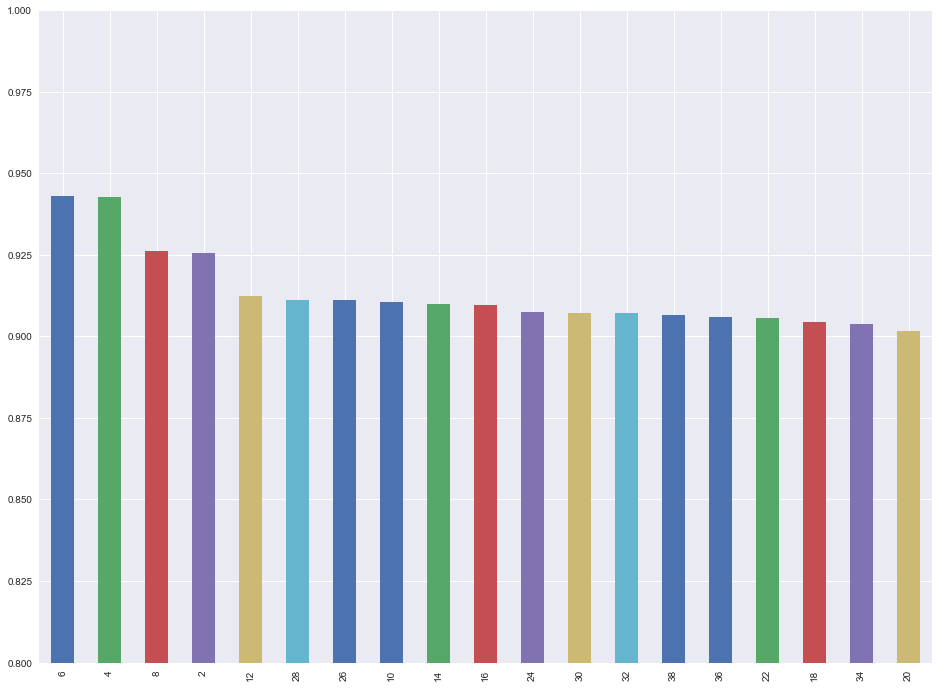

In [ ]:
res.sort_values("test", ascending=False).test.plot.bar(ylim=(0.8, 1))

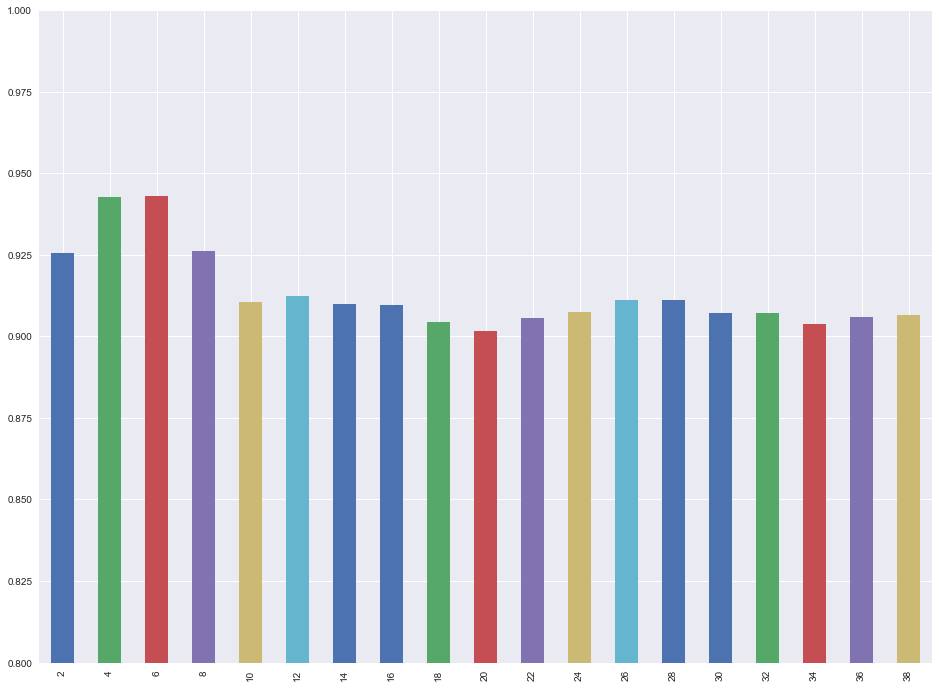

In [ ]:
res.test.plot.bar(ylim=(0.8, 1))